# Simple Linear Regression

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

plt.rcParams['figure.figsize'] = (16, 8)

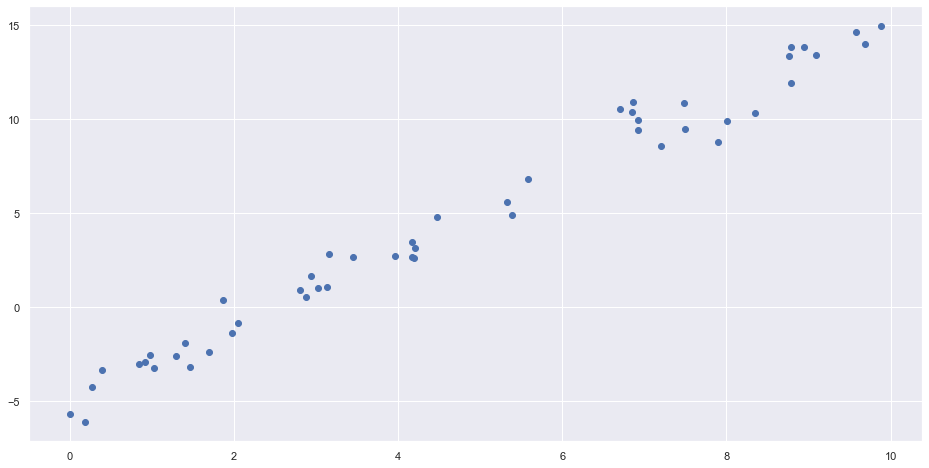

In [2]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y)

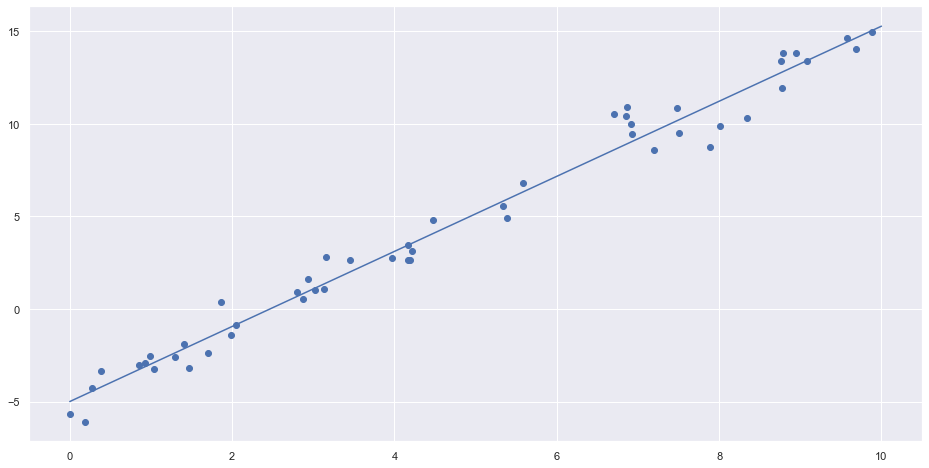

In [3]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)

In [4]:
print('Model slope:    ', model.coef_[0])     # Slope = a from 'ax + b'
print('Model intercept:', model.intercept_)  # Intercept = b from 'ax + b'

Model slope:     2.0272088103606944
Model intercept: -4.9985770855532


# Basis Function Regression

The idea is to take our multidimensional linear model:

y = a0 + a1x1 + a2x2 + a3x3 + ...

and build the x1, x2, x3, and so on from our single-dimensional input x. That is, we let xn = fn(x), where fn() is some function that transforms our data.

For example, if fn(x) = x^n , our model becomes a polynomial regression:

y = a0 + a1x + a2x^2 + a3x^3 + ...

Notice that this is still a linear model — the linearity refers to the fact that the coefficients **an** never multiply or divide each other. What we have effectively done is taken our one-dimensional x values and projected them into a higher dimension, so that a linear fit can fit more complicated relationships between x and y.

### Polynomial Basis Functions

In [5]:
from sklearn.preprocessing import PolynomialFeatures

x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

In [6]:
# using pipeline

from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7),
                           LinearRegression())

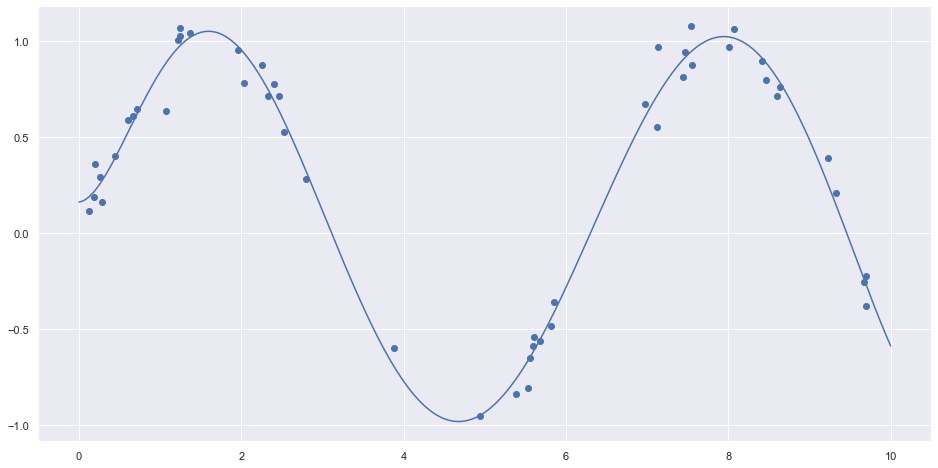

In [7]:
rgn = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)

### Gaussian Basis Functions

(0.0, 10.0)

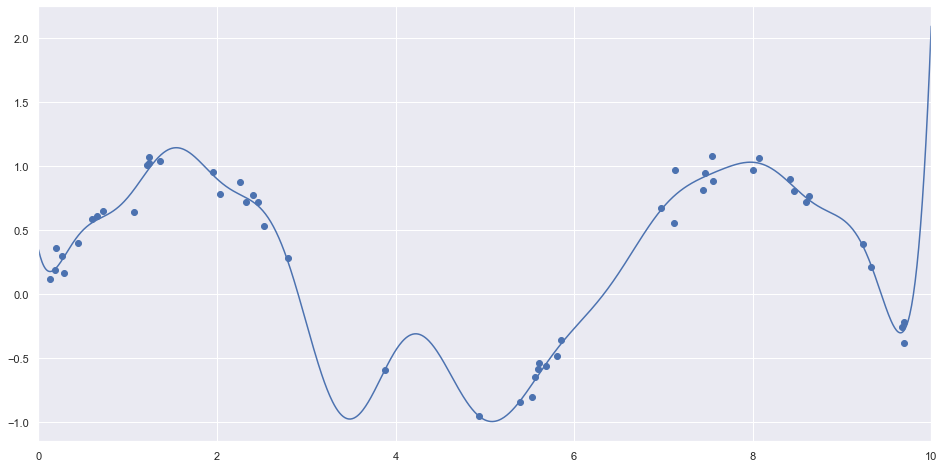

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
        
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
    
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
    
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_, self.width_, axis=1)
    
gauss_model = make_pipeline(GaussianFeatures(20),
                            LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10)

# Regularization

Introducing basis finctions to linear regression model might lead to overfitting

(-1.5, 1.5)

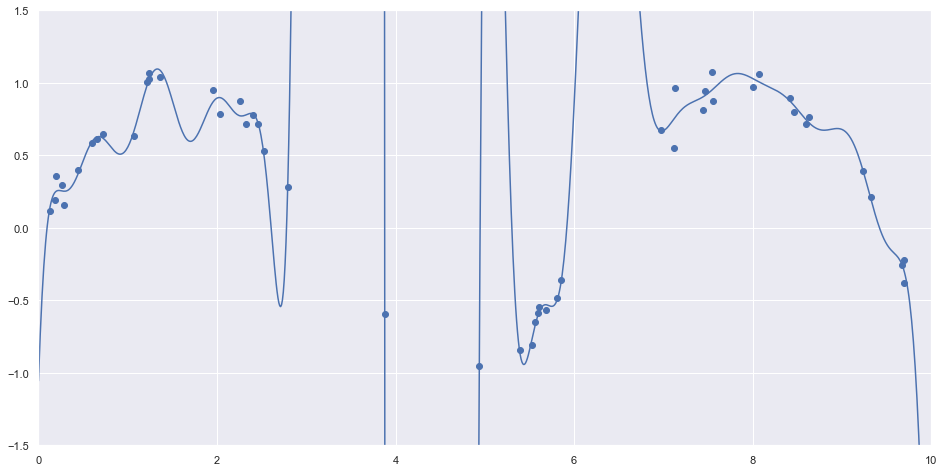

In [9]:
model = make_pipeline(GaussianFeatures(30),
                      LinearRegression())
model.fit(x[:, np.newaxis], y)

plt.scatter(x, y)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))
plt.xlim(0, 10)
plt.ylim(-1.5, 1.5)

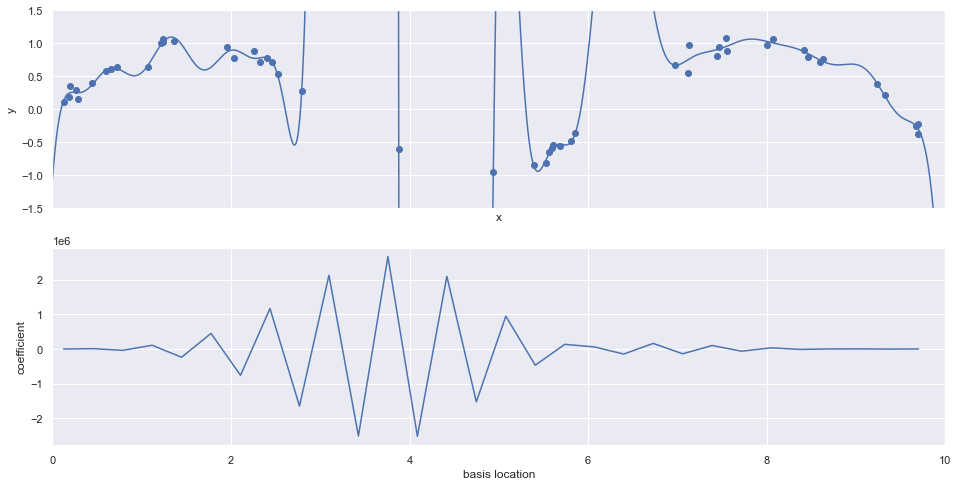

In [10]:
# checking reasons by plotting coefficients of Gaussian bases with respect to their locations

def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    
    if title:
        ax[0].set_title(title)
        
    ax[1].plot(model.steps[0][1].centers_,
               model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location', ylabel='coefficient', xlim=(0, 10))
    
model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model)

The lower panel shows the amplitude of the basis function at each location. This is typical overfitting behavior when basis functions overlap: the coefficients of adjacent basis functions blow up and cancel each other out. We know that such behavior is problematic, and it would be nice if we could limit such spikes explicitly in the model by penalizing large values of the model parameters. Such a penalty is known as regularization, and comes in several forms.

### Ridge regression ($L_2$ regularization)

Perhaps the most common form of regularization is known as ridge regression or $L_2$ regularization, sometimes also called Tikhonov regularization. This proceeds by penalizing the sum of squares (2-norms) of the model coefficients; in this case, the penalty on the model fit would be:

P = $\alpha$$\sum_{n=1}^{N}$$\theta_{n}^{2}$

where α is a free parameter that controls the strength of the penalty.

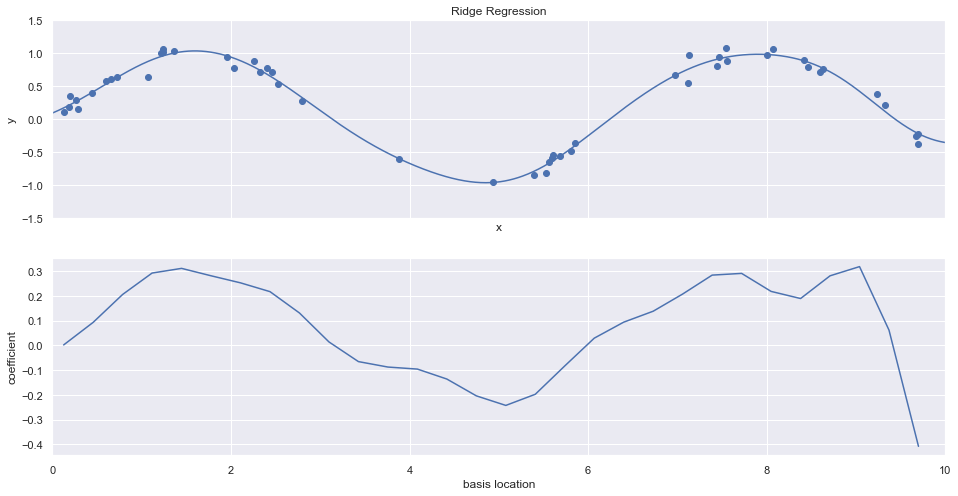

In [11]:
from sklearn.linear_model import Ridge

model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
basis_plot(model, title='Ridge Regression')

The α parameter is essentially a knob controlling the complexity of the resulting model. In the limit α --> 0, we recover the standard linear regression result; in the limit α --> ∞, all model responses will be suppressed. One advantage of ridge regression in particular is that it can be computed very efficiently—at hardly more computational cost than the original linear regression model.

### Lasso regularization ($L_1$)

Another very common type of regularization is known as lasso, and involves penalizing the sum of absolute values (1-norms) of regression coefficients:

P = $\alpha$$\sum_{n=1}^{N}$$|\theta_{n}|$

Though this is conceptually very similar to ridge regression, the results can differ surprisingly: for example, due to geometric reasons lasso regression tends to favor sparse models where possible; that is, it preferentially sets model coefficients to exactly zero.

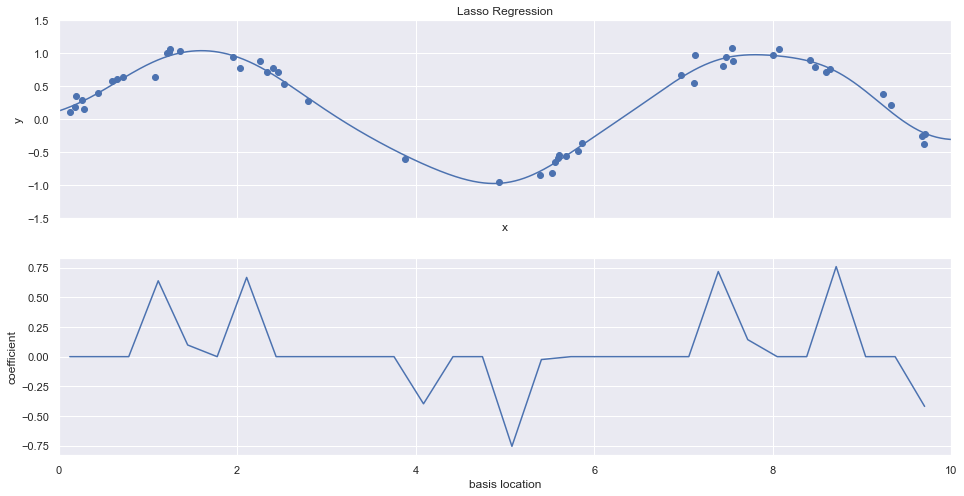

In [12]:
from sklearn.linear_model import Lasso

model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.001))
basis_plot(model, title='Lasso Regression')

With the lasso regression penalty, the majority of the coefficients are exactly zero, with the functional behavior being modeled by a small subset of the available basis functions. As with ridge regularization, the α parameter tunes the strength of the penalty, and should be determined via, for example, cross-validation.